# Import necessary modules

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import os
import time
import pandas as pd
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

# Install timm to access ViT PyTorch Models

In [2]:
pip install '../input/timm034/timm-0.3.4-py3-none-any.whl'

Processing /kaggle/input/timm034/timm-0.3.4-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


# Import timm

In [3]:
import timm

# Display Available Vision Transformer Models

In [4]:
print("Available ViT Models: ")
timm.list_models("vit*")

Available ViT Models: 


['vit_base_patch16_224',
 'vit_base_patch16_384',
 'vit_base_patch32_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50d_224',
 'vit_huge_patch16_224',
 'vit_huge_patch32_384',
 'vit_large_patch16_224',
 'vit_large_patch16_384',
 'vit_large_patch32_384',
 'vit_small_patch16_224',
 'vit_small_resnet26d_224',
 'vit_small_resnet50d_s3_224']

In [5]:
data_path  = '../input/cassava-leaf-disease-classification/'
train_path = '../input/cassava-leaf-disease-classification/train_images/'
test_path  = '../input/cassava-leaf-disease-classification/test_images/'
model_path = '../input/vitbase16224/jx_vit_base_p16_224-80ecf9dd.pth'
Cassava_model = '../input/cassavanewaugtp95epochs3/CassavaViT_newaug_TP95_Epochs3_LR1-75e05.pt'

# Define ViTBase 16 class

In [6]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        
        if pretrained:
            self.model.load_state_dict(torch.load(model_path))
            
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)
    
    def forward(self, x):
        x = self.model(x)
        return x

# Create cassava pre-trained ViTBase16 model instance (5 classes)

In [7]:
cassava_model = ViTBase16(n_classes=5, pretrained=True)
cassava_model.load_state_dict(torch.load(Cassava_model))
cassava_gpu_model = cassava_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cassava_gpu_model.parameters(), lr=1.5e-05)
cassava_gpu_model

ViTBase16(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), 

# Examine test image folder

In [8]:
test_img_names = []
for folder, subfolders, filenames in os.walk(test_path):
    print('************************************************FOLDER************************************************')
    print(folder)
    print('************************************************IMAGES************************************************')
    for img in filenames:
        print(img)
        if img[-3:] == 'jpg':
            test_img_names.append(img)        
print('Testing Images: ',len(test_img_names))

************************************************FOLDER************************************************
../input/cassava-leaf-disease-classification/test_images/
************************************************IMAGES************************************************
2216849948.jpg
Testing Images:  1


# Create class to load test data (adds image names)

In [9]:
class TestSet2(Dataset):
    """Cassava Disease Dataset"""

    def __init__(self, root_dir, test_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with test image names.
            root_dir (string): Directory with all the test images.
            transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        super().__init__()
        self.root_dir = root_dir
        self.test_dir = test_dir
        self.transform = transform
        print(root_dir)
        print(test_dir)
        print("Cassava Disease Test Dataset Length = ", len(os.listdir(self.test_dir)))


    def __len__(self):
        return len(os.listdir(self.test_dir))


    def __getitem__(self, idx):
        img_path = self.test_dir + os.listdir(self.test_dir)[idx] 
        img = Image.open(img_path).convert("RGB")
        image_name = os.listdir(self.test_dir)[idx]

        
        if self.transform:
            image = self.transform(img)
    
        return (image, image_name)

# Create test transforms (needed for image resizing)

In [10]:
test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

# Create test dataset

In [11]:
testset = TestSet2(root_dir = '' , test_dir=test_path, transform = test_transform)
print(testset)


../input/cassava-leaf-disease-classification/test_images/
Cassava Disease Test Dataset Length =  1


# Load the test dataset

In [12]:
test_batch_size = 1
test_loader = DataLoader(dataset=testset, batch_size=test_batch_size, shuffle=True, pin_memory=True)

# Check to see if test_loader is working

['2216849948.jpg']


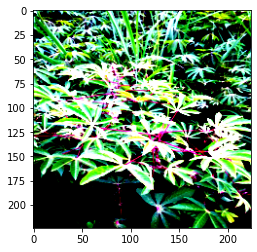

In [13]:
print(test_loader)

# Grab the first batch of 16 images
for images,names in test_loader: 
    break

im = make_grid(images, nrow=4)  # the default nrow is 8

# Inverse normalize the images
#inv_normalize = transforms.Normalize(
#    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
#    std=[1/0.229, 1/0.224, 1/0.225]
#)
#im_inv = inv_normalize(im)
print(names)
# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# Used trained model to generate test data predictions
# Generate submission file

In [14]:
test_losses = []
test_correct = []
col_names =  ['image_id', 'label']
submission_df = pd.DataFrame(columns = col_names)
tic = time.time()
with torch.no_grad():
    for b, (X_test, name) in enumerate(test_loader):
        X_test = X_test.cuda()
        # Apply the model
        y_test_pred = cassava_gpu_model(X_test)
        predicted = torch.max(y_test_pred.data, 1)[1]
        label = int(predicted)
        image_name = name[0]
        new_row = {'image_id': image_name, 'label': label}
        submission_df = submission_df.append(new_row, ignore_index=True)
        
toc = time.time() - tic
print('Time for model val is ', toc)
#display(submission_df)
submission_df.to_csv('submission.csv', index=False)
df_sub_test = pd.read_csv('submission.csv')
display(df_sub_test)
!ls

Time for model val is  0.8213293552398682


,image_id,label
0,2216849948.jpg,2


__notebook__.ipynb  submission.csv
